In [1]:
from predict import getMask
import cv2
import numpy as np
import torch
from matplotlib import pyplot as plt
import style.utils as utils
from style.CLIPstyler import getStyleImg
from torchvision import transforms, models
import torch.nn.functional as F
import clip

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'




/data15/chenjh2309/.conda/envs/soulstyler/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

mask_path = "./mask/5.jpg"
img_path = "./testimg/Napoleon.jpg"
sent = "the a white with sails on blue"
sent = "a white boat with blue sails on the sea"
sent = "A white boat with blue sails gracefully sails across the sea."
sent = "The boat is a magnificent vessel adorned with three majestic blue sails. Its towering and grand hull commands attention and awe. The pristine white body gleams with a smooth coating, shimmering in the sunlight. Each piece of blue fabric unfurled on the masts exhibits a deep and vibrant shade, creating a striking contrast against the surrounding sea. The sails are securely fastened to the masts with delicate ropes, billowing and dancing in the wind, as if embarking on a journey to the unknown. The beauty and grandeur of this boat are captivating, making it a shining star upon the vast ocean."
sent = "the horse"
sent = "a white horse under people"

config_path = "./config/refcoco+/test.yaml"
model_pth = "./best_model.pth"
text = "Starry Night by Vincent van gogh"

cuda


In [3]:
def getMaskImg(img,config_path,model_pth,sent=None,isMask=False,):
    if not isMask:
        img_style1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_style2 = img_style1/255.0
        img_style3 = np.transpose(img_style2, (2,0,1))
        img_style4 = torch.Tensor(img_style3)
        img_style = torch.unsqueeze(img_style4, 0)
    
        mask0 = getMask(img,sent,config_path,model_pth)
        mask1 = np.stack((mask0, mask0,mask0), axis=2)
        mask_img = np.array(mask1*255, dtype=np.uint8)
        return mask_img
    else:
        return img
    
def getCVImg2Torch(img):
    img_style1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img_style1 = img
    img_style2 = img_style1/255.0
    img_style3 = np.transpose(img_style2, (2,0,1))
    img_style4 = torch.Tensor(img_style3)
    img_style = torch.unsqueeze(img_style4, 0)
    return img_style

def load_image(img,mode="PLT"):
    if mode == "CV":
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    transform = transforms.Compose([
                        transforms.ToTensor(),
                        ])   
    image = transform(img)[:3, :, :].unsqueeze(0)
    return image

def squeeze_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze(0)
    image = torch.Tensor(image)
    return image


def img_normalize(image,device):
    mean=torch.tensor([0.485, 0.456, 0.406]).to(device)
    std=torch.tensor([0.229, 0.224, 0.225]).to(device)
    mean = mean.view(1,-1,1,1)
    std = std.view(1,-1,1,1)

    image = (image-mean)/std
    return image

def clip_normalize(image,device):
    image = F.interpolate(image,size=224,mode='bicubic')
    mean=torch.tensor([0.48145466, 0.4578275, 0.40821073]).to(device)
    std=torch.tensor([0.26862954, 0.26130258, 0.27577711]).to(device)
    mean = mean.view(1,-1,1,1)
    std = std.view(1,-1,1,1)

    image = (image-mean)/std
    return image

def clip_normalize2(image,device):
    image = F.interpolate(image,size=224,mode='bicubic')
    return image

def get_image_prior_losses(inputs_jit):
    diff1 = inputs_jit[:, :, :, :-1] - inputs_jit[:, :, :, 1:]
    diff2 = inputs_jit[:, :, :-1, :] - inputs_jit[:, :, 1:, :]
    diff3 = inputs_jit[:, :, 1:, :-1] - inputs_jit[:, :, :-1, 1:]
    diff4 = inputs_jit[:, :, :-1, :-1] - inputs_jit[:, :, 1:, 1:]

    loss_var_l2 = torch.norm(diff1) + torch.norm(diff2) + torch.norm(diff3) + torch.norm(diff4)
    
    return loss_var_l2

def getClipFeature(image,clip_model):
    image = F.interpolate(image,size=224,mode='bicubic')
    image = clip_model.encode_image(image.to(device))
    image = image.mean(axis=0, keepdim=True)
    image /= image.norm(dim=-1, keepdim=True)
    return image

def getVggFeature(image,device,VGG):
    return utils.get_features(img_normalize(image,device), VGG)

def getLoss(text_feature,img_feature):
    return 1-torch.cosine_similarity(text_feature, img_feature)

def getCropImgAndFeature(img,mask,target,clip_model,size=128,batch=64,pot_part=0.9,sizePose=None):
    back_crop, pot_crop ,pot_aug,extra_pot = [], [],[],[]
    cropper = transforms.RandomCrop(size)
    augment = transforms.Compose([
        transforms.RandomPerspective(fill=0, p=1,distortion_scale=0.5),
        transforms.Resize(400)
    ])
    while len(pot_crop)<batch  :
        if sizePose:
            (i, j, h, w) = sizePose
        else:
            (i, j, h, w) = cropper.get_params(squeeze_convert(mask), (size, size))
        
        mask_crop = transforms.functional.crop(mask, i, j, h, w)
        img_crop = transforms.functional.crop(img, i, j, h, w)
        target_crop = transforms.functional.crop(target, i, j, h, w)
        
        if int(mask_crop[0].sum())/(3*size*size) >= 0.8:
            if len(pot_crop)<batch :
                pot_crop.append(img_crop)
                pot_aug.append(augment(target_crop))
    
    pot_allCrop = torch.cat(pot_crop,dim=0)
    pot_all_crop = pot_allCrop


    pot_crop_feature = clip_model.encode_image(clip_normalize2(pot_all_crop,device))
    while len(back_crop) < batch:
        (i, j, h, w) = cropper.get_params(squeeze_convert(mask), (size, size))
        mask_crop = transforms.functional.crop(mask, i, j, h, w)
        img_crop = transforms.functional.crop(img, i, j, h, w)
        target_crop = transforms.functional.crop(target, i, j, h, w)
        if int(mask_crop[0].sum())/(3*size*size) < 0.1:
            img_crop_feature = clip_model.encode_image(clip_normalize2(img_crop,device))
            cos = (1- torch.cosine_similarity(img_crop_feature, pot_crop_feature))
            if torch.numel(cos[cos>0.12]) > 0.8*batch:
                back_crop.append([target_crop,img_crop])
    while len(extra_pot) < 0.1*batch:
        (i, j, h, w) = cropper.get_params(squeeze_convert(mask), (size, size))
        mask_crop = transforms.functional.crop(mask, i, j, h, w)
        img_crop = transforms.functional.crop(img, i, j, h, w)
        target_crop = transforms.functional.crop(target, i, j, h, w)
        if int(mask_crop[0].sum())/(3*size*size) < 0.1:
            img_crop_feature = clip_model.encode_image(clip_normalize2(img_crop,device))
            cos = (1- torch.cosine_similarity(img_crop_feature, pot_crop_feature))
            if torch.numel(cos[cos<0.06]) > 0.2*batch:
                extra_pot.append(augment(target_crop))
                pot_aug.append(augment(target_crop))
    return pot_aug,back_crop

def getTotalLoss1(args,content_features,text_features,source_features,text_source,target,device,VGG,clip_model,img,mask):
    cropper = transforms.Compose([
    transforms.RandomCrop(args.crop_size)
    ])
    augment = transforms.Compose([
    transforms.RandomPerspective(fill=0, p=1,distortion_scale=0.5),
    transforms.Resize(224)
    ])
    loss_patch=0 
    img_crop,back_crop = getCropImgAndFeature(img,mask,target,clip_model,size=64,batch=64,pot_part=args.pot_part,sizePose=None)
    
    img_crop = torch.cat(img_crop,dim=0)
    img_aug = img_crop
    image_features = clip_model.encode_image(clip_normalize(img_aug,device))
    image_features /= (image_features.clone().norm(dim=-1, keepdim=True))
    img_direction = (image_features-source_features)
    img_direction /= img_direction.clone().norm(dim=-1, keepdim=True)

    text_direction = (text_features-text_source).repeat(image_features.size(0),1)
    text_direction /= text_direction.norm(dim=-1, keepdim=True)
    loss_temp = (1- torch.cosine_similarity(img_direction, text_direction, dim=1))
    loss_temp[loss_temp<args.thresh] =0
    loss_patch+=loss_temp.mean()
    
    
    loss_back = 0
    lossToBack = torch.nn.MSELoss()
    for i in back_crop:
        a = i[0]
        b = i[1]
        loss_back += lossToBack(a, b)
    target_features = utils.get_features(img_normalize(target,device), VGG)
    content_loss = 0
    content_loss += torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)
    content_loss += torch.mean((target_features['conv5_2'] - content_features['conv5_2']) ** 2)
    loss_glob=0
    reg_tv = args.lambda_tv*get_image_prior_losses(target)
    total_loss = args.lambda_patch*loss_patch + args.lambda_c * content_loss+ reg_tv+ args.lambda_dir*1*loss_glob+args.lambda_c *1* loss_back

    detail_loss = {
        "loss_patch":loss_patch,
        "content_loss":content_loss,
        "reg_tv":reg_tv,
        "loss_glob":loss_glob,
        "loss_back":loss_back,
    }

    return total_loss,detail_loss

2023-11-23 01:23:46.498 | INFO     | model:build_segmenter:46 - Backbone with decay=325, Head=124


vis.shape=torch.Size([676, 1, 512])
txt.shape=torch.Size([17, 1, 512])
vis_pos.shape=torch.Size([676, 1, 512])
txt_pos.shape=torch.Size([17, 1, 512])
pad_mask.shape=torch.Size([1, 17])
vis2.shape=torch.Size([676, 1, 512])
vis_pos.shape=torch.Size([676, 1, 512])
txt.shape=torch.Size([17, 1, 512])
txt_pos.shape=torch.Size([17, 1, 512])
pad_mask.shape=torch.Size([1, 17])
vis.shape=torch.Size([676, 1, 512])
txt.shape=torch.Size([17, 1, 512])
vis_pos.shape=torch.Size([676, 1, 512])
txt_pos.shape=torch.Size([17, 1, 512])
pad_mask.shape=torch.Size([1, 17])
vis2.shape=torch.Size([676, 1, 512])
vis_pos.shape=torch.Size([676, 1, 512])
txt.shape=torch.Size([17, 1, 512])
txt_pos.shape=torch.Size([17, 1, 512])
pad_mask.shape=torch.Size([1, 17])
vis.shape=torch.Size([676, 1, 512])
txt.shape=torch.Size([17, 1, 512])
vis_pos.shape=torch.Size([676, 1, 512])
txt_pos.shape=torch.Size([17, 1, 512])
pad_mask.shape=torch.Size([1, 17])
vis2.shape=torch.Size([676, 1, 512])
vis_pos.shape=torch.Size([676, 1, 51

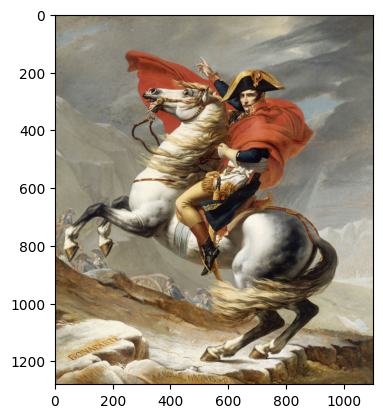

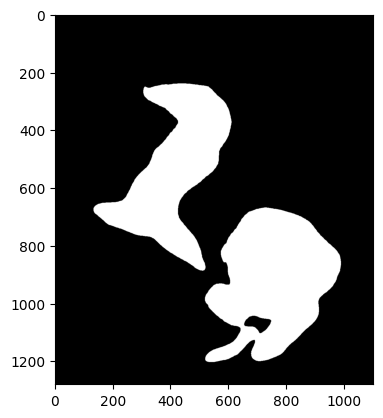

In [4]:
img = cv2.imread(img_path)
mask_img = cv2.imread(mask_path)

sent = "the horse"
sent = "a white horse"
sent = "the white horse"
sent = "Horse"
sent = "a white horse"
sent = 'White War Horse'
sent = 'the White War Horse'
# sent = 'a White War Horse'
# sent = 'White Stallion'
# sent = 'a White Stallion'
# sent = 'the White Stallion'
sent = 'A white warhorse'
# sent = 'white warhorse'
# sent = 'the white warhorse'

mask = getMaskImg(img,config_path,model_pth,sent,isMask=False)

img = load_image(img,mode="CV")
mask = load_image(mask)

plt.imshow(utils.im_convert2(img))
plt.show()
plt.imshow(utils.im_convert2(mask))
plt.show()



In [5]:
output_image = getStyleImg(
    config_path,img,source="a Photo",
    prompt="pop art of night city",
    seed=6,
    get_total_loss=getTotalLoss1,
    mask=mask
    )
plt.figure(figsize=(20, 20))#6，8分别对应宽和高
plt.imshow(utils.im_convert2(output_image))
plt.show()

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 274 but got size 275 for tensor number 1 in the list.